# Вывод:

Лучший результат у меня показала модель SVM с настройками по-умолчанию (предпоследняя строка 'top20 SVM' в таблице результатов). 

Причем подбор параметров модели SVM выбрал отличные от дефолтных показатели. Что весьма странно(

Я понимаю, что не совсем верно, подбирать параметры отдельно. Но у меня слишком много времени уходило на подбор параметров. Особенно с ядром 'poly' сильно долго учится 

Могу предположить, это из-за того, что я в GridSearchCV сократил количество Фолдов до 3 (cv = 3). Это могло повлиять на подбор оптимальных параметров. Сделал это для увеличения скорости обучения.


In [77]:
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661
top30 LogReg,0.711,0.946,0.723,0.819,0.657
top20 KNN,0.663,0.832,0.724,0.774,0.574
top20 SVM,0.704,0.962,0.712,0.819,0.647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score


In [2]:
data = pd.read_csv('train.csv')
data.head()


,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,4.012088,7.711453,7.653429,12.707581,2.015505,10.498338,9.848672,0.113561,C,12.171733,8.086643,0.899420,7.277792,G,16.747968,0.037096,1.299638,DI,3.971118,0.529802,10.890984,1.588448,15.858152,1,0.153461,6.363189,18.303925,C,9.314079,15.231789,17.142857,11.784549,F,1,1.614988,B,D,2.230940,7.292418,8.571429,E,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,0.095678,0.905342,A,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,NaN,14.305766,NaN,NaN,NaN,NaN,NaN,2.449959,E,NaN,NaN,1.379210,NaN,G,NaN,1.129469,NaN,DY,NaN,NaN,NaN,NaN,NaN,2,2.544736,NaN,NaN,A,NaN,NaN,NaN,12.053353,F,2,NaN,B,D,NaN,NaN,NaN,D,NaN,7.277655,3.430691,NaN,NaN,NaN,NaN,9.848004,NaN,2.678584,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,7.378964,13.077201,6.173469,12.346939,2.926830,8.897561,5.343819,0.126035,C,12.711328,6.836734,0.604504,9.637627,F,15.102041,0.085573,0.765305,AS,4.030613,4.277456,9.105481,2.151361,16.075602,1,0.123643,5.517949,16.377205,A,8.367347,11.040463,5.882353,8.460654,B,3,2.413618,B,B,1.963971,5.918368,11.764705,E,3.333334,10.194433,8.266200,1.530611,1.530613,2.429906,1.071429,8.447465,3.367346,0.111388,0.811447,G,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,0.287322,11.523045,7.931035,12.935823,1.470878,12.708574,9.670823,0.108387,C,12.194855,8.591954,3.329176,4.780357,H,16.621695,0.139721,1.178161,BW,3.965517,1.732102,11.777912,1.229246,15.927390,1,0.140260,6.292979,17.011645,A,9.703065,18.568129,9.425288,13.594728,F,2,2.272541,B,D,2.188198,8.213602,13.448277,B,1.947261,4.797873,13.315819,1.681034,1.379310,1.587045,1.242817,10.

In [3]:
print(data.shape[0], data['ID'].nunique())


114321 114321


In [4]:
# Удалим столбец ID в обоих датасетах:
data.drop('ID', axis = 1, inplace = True)

print(data.shape)


(114321, 132)


In [5]:
# Для увеличения скорости обучения сократим количество данных, удалив все объекты с пропусками.

In [6]:
df = data.dropna()
df.shape


(17756, 132)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17756 entries, 21 to 114313
Columns: 132 entries, target to v131
dtypes: float64(108), int64(5), object(19)
memory usage: 18.0+ MB


In [8]:
df.describe()


,target,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v23,v25,v26,v27,v28,v29,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v48,v49,v50,v51,v53,v54,v55,v57,v58,v59,v60,v61,v62,v63,v64,v65,v67,v68,v69,v70,v72,v73,v76,v77,v78,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v108,v109,v111,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
count,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.00000,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,1.775600e+04,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04
mean,0.698524,1.581795e+00,7.718066,4.150417,8.639190,2.416121e+00,2.515759,1.213122,9.165634e+00,1.511103e+00,15.496623,6.660256,3.676209,11.689455,2.054269e+00,5.006005e+00,3.694357,0.794715,0.219796,17.781978,6.800641,8.616850e-01,1.364652,1.843712,2.778045,4.877228,8.192650,1.601948e+00,2.103487,6.290400,8.126512,1.325481e+01,7.054593e-01,0.011545,1.290234e+00,10.274940,7.170861,12.871728,2.186958,10.736608,9.228891,1.325310,12.586787,8.000458,1.359591,7.257796,15.770167,0.992727,1.512214e+00,4.124008,6.454041e+00,10.623467,1.686826,14.762705,1.226684,1.370482,6.203672,15.912751,9.244492,17.532916,9.409983e+00,12.198875,1.26943,2.412853e+00,2.296910,7.277737,1.326671e+01,2.247441e+00,7.364381,6.746790,2.102643e+00,1.591948e+00,2.684883e+00,1.203916e+00,9.957188,1.948392e+00,1.201045,0.976332,0.569889,5.355642,3.841668,0.649261,6.469922,7.391881,7.827800e+00,1.236194e+00,1.335044e+01,6.861227,2.635913e+00,5.272000,2.567722,0.838182,11.789319,2.100103,3.809269e+00,3.285833e+00,13.677014,1.058778e+01,2.257686,7.768359e+00,8.097694,2.845292e+00,1.273373e+00,2.656720e+00,6.918134e+00,3.337316,6.866304e-01,1.671814,3.239106,1.954987,0.031201,1.837441,1.724998e+00
std,0.458912,1.051938e+00,2.987010,1.036288,2.135488,5.762233e-01,0.575772,2.552911,1.865808e+00,8.102275e-01,0.763330,0.560050,1.090297,0.939782,7.046548e-01,1.774767e+00,1.636100,0.633656,0.273016,1.148800,0.840446,3.525369e+00,2.666307,0.527203,0.814027,2.751891,1.237888,5.394018e-01,0.936903,2.028949,1.269724,2.270394e+00,4.984577e-01,0.201743,2.348589e+00,3.118179,0.949794,0.938576,0.619174,1.953597,1.951022,2.653656,2.020093,0.838216,1.054733,2.399272,0.771313,2.047478,8.010419e-01,0.649182,6.408993e+00,2.008100,0.512398,2.045228,0.582607,2.704158,2.240873,1.830640,1.068604,2.279562,1.907081e+00,2.342501,0.61891,7.683210e-01,1.156657,1.222712,1.830921e+00,1.066203e+00,2.206950,3.758836,1.005665e+00,9.061417e-01,1.372304e+00,4.491023e-01,2.922904,1.030242e+00,2.511640,0.161030,0.220902,1.432850,0.833077,0.243401,1.075664,1.802487,2.266278e+00,4.442030e-0

In [9]:
object_features = [i for i in df if df[i].dtypes == object]
object_features


['v3',
 'v22',
 'v24',
 'v30',
 'v31',
 'v47',
 'v52',
 'v56',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125']

In [10]:
df[object_features].describe()


,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
count,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756,17756
unique,2,6998,5,7,3,7,12,62,3,3,2,2,11,7,7,2,22,34,86
top,C,YGJ,E,C,A,I,J,DO,A,F,B,D,C,A,E,A,F,G,BM
freq,17755,351,6313,10523,17391,10861,1740,2777,11554,12563,17655,12563,9495,4108,4108,16771,2610,5207,1018


In [11]:
int_features = [i for i in df if df[i].dtypes == 'int64']
int_features.remove('target')
int_features


['v38', 'v62', 'v72', 'v129']

In [12]:
df[int_features].describe()


,v38,v62,v72,v129
count,17756.000000,17756.000000,17756.00000,17756.000000
mean,0.011545,1.226684,1.26943,0.031201
std,0.201743,0.582607,0.61891,0.228215
min,0.000000,0.000000,1.00000,0.000000
25%,0.000000,1.000000,1.00000,0.000000
50%,0.000000,1.000000,1.00000,0.000000
75%,0.000000,1.000000,1.00000,0.000000
max,9.000000,7.000000,9.00000,4.000000


In [13]:
for i in int_features:
    print(df[i].nunique())


8
8
8
5


In [14]:
# целочисленные признаки имеют малое количество уникальных значений, поэтому отнесем их к категориальным признакам:
object_features = object_features + int_features


In [15]:
float_features = [i for i in df if df[i].dtypes == 'float64']
len(float_features)


108

In [16]:
object_float_features = [i for i in float_features if df[i].nunique() <= 100]
len(object_float_features)


0

In [17]:
df[float_features].describe()


,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v23,v25,v26,v27,v28,v29,v32,v33,v34,v35,v36,v37,v39,v40,v41,v42,v43,v44,v45,v46,v48,v49,v50,v51,v53,v54,v55,v57,v58,v59,v60,v61,v63,v64,v65,v67,v68,v69,v70,v73,v76,v77,v78,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v108,v109,v111,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v126,v127,v128,v130,v131
count,1.775600e+04,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,1.775600e+04,17756.000000,1.775600e+04,1.775600e+04,1.775600e+04,1.775600e+04,17756.000000,1.775600e+04,17756.000000,17756.000000,17756.000000,17756.000000,1.775600e+04
mean,1.581795e+00,7.718066,4.150417,8.639190,2.416121e+00,2.515759,1.213122,9.165634e+00,1.511103e+00,15.496623,6.660256,3.676209,11.689455,2.054269e+00,5.006005e+00,3.694357,0.794715,0.219796,17.781978,6.800641,8.616850e-01,1.364652,1.843712,2.778045,4.877228,8.192650,1.601948e+00,2.103487,6.290400,8.126512,1.325481e+01,7.054593e-01,1.290234e+00,10.274940,7.170861,12.871728,2.186958,10.736608,9.228891,1.325310,12.586787,8.000458,1.359591,7.257796,15.770167,0.992727,1.512214e+00,4.124008,6.454041e+00,10.623467,1.686826,14.762705,1.370482,6.203672,15.912751,9.244492,17.532916,9.409983e+00,12.198875,2.412853e+00,2.296910,7.277737,1.326671e+01,2.247441e+00,7.364381,6.746790,2.102643e+00,1.591948e+00,2.684883e+00,1.203916e+00,9.957188,1.948392e+00,1.201045,0.976332,0.569889,5.355642,3.841668,0.649261,6.469922,7.391881,7.827800e+00,1.236194e+00,1.335044e+01,6.861227,2.635913e+00,5.272000,2.567722,0.838182,11.789319,2.100103,3.809269e+00,3.285833e+00,13.677014,1.058778e+01,2.257686,7.768359e+00,8.097694,2.845292e+00,1.273373e+00,2.656720e+00,6.918134e+00,3.337316,6.866304e-01,1.671814,3.239106,1.954987,1.837441,1.724998e+00
std,1.051938e+00,2.987010,1.036288,2.135488,5.762233e-01,0.575772,2.552911,1.865808e+00,8.102275e-01,0.763330,0.560050,1.090297,0.939782,7.046548e-01,1.774767e+00,1.636100,0.633656,0.273016,1.148800,0.840446,3.525369e+00,2.666307,0.527203,0.814027,2.751891,1.237888,5.394018e-01,0.936903,2.028949,1.269724,2.270394e+00,4.984577e-01,2.348589e+00,3.118179,0.949794,0.938576,0.619174,1.953597,1.951022,2.653656,2.020093,0.838216,1.054733,2.399272,0.771313,2.047478,8.010419e-01,0.649182,6.408993e+00,2.008100,0.512398,2.045228,2.704158,2.240873,1.830640,1.068604,2.279562,1.907081e+00,2.342501,7.683210e-01,1.156657,1.222712,1.830921e+00,1.066203e+00,2.206950,3.758836,1.005665e+00,9.061417e-01,1.372304e+00,4.491023e-01,2.922904,1.030242e+00,2.511640,0.161030,0.220902,1.432850,0.833077,0.243401,1.075664,1.802487,2.266278e+00,4.442030e-01,6.447878e+00,2.218867,1.487399e+00,1.180855,0.834745,1.978504,2.763392,0.830289,3.292163e+00,1.411005e+00,2.558484,1.908609e+00,0.641761,3.514189e+00,1.867082,3.8698

In [18]:
Corr = df.corr()

CorField = []
CorPairs = []
CorrDel = []

for i in Corr:
    for j in Corr.index[Corr[i] > 0.85]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            CorPairs.append([i, j, Corr[i][Corr.index == j].values[0]])
            CorrDel.append(i)
            print (i, '-->', j, ': R =', Corr[i][Corr.index == j].values[0])


v1 --> v37 : R = 0.9008821561540451
v8 --> v25 : R = 0.9467233735263951
v8 --> v46 : R = 0.9769724360371036
v8 --> v54 : R = 0.8651836769452624
v8 --> v63 : R = 0.976670789599985
v8 --> v89 : R = 0.8824595172154179
v8 --> v105 : R = 0.9260048575552497
v11 --> v53 : R = 0.9549541935054765
v13 --> v104 : R = 0.9266588356709027
v15 --> v32 : R = 0.8936881316804419
v15 --> v73 : R = 0.9436929650348758
v15 --> v86 : R = 0.8547105687152112
v17 --> v64 : R = 0.9843927781104301
v17 --> v76 : R = 0.9931160584981272
v17 --> v93 : R = 0.8613119428809572
v17 --> v106 : R = 0.873724251846451
v20 --> v65 : R = 0.9119338228101596
v26 --> v43 : R = 0.9113781901570088
v26 --> v60 : R = 0.9801085002159742
v26 --> v116 : R = 0.872988984084495
v29 --> v41 : R = 0.9068258017622153
v29 --> v67 : R = 0.9278498827135107
v29 --> v77 : R = 0.9175398413539906
v29 --> v96 : R = 0.9572913775994968
v33 --> v55 : R = 0.9413183347800804
v33 --> v83 : R = 0.9631863964711768
v33 --> v111 : R = 0.9236491877105893
v33 --

In [19]:
# Посмотрим на коррелируемые признаки:
CorrDel = set(CorrDel)
CorrDel


{'v1',
 'v108',
 'v11',
 'v119',
 'v13',
 'v15',
 'v17',
 'v20',
 'v26',
 'v29',
 'v33',
 'v34',
 'v62',
 'v8',
 'v92',
 'v97'}

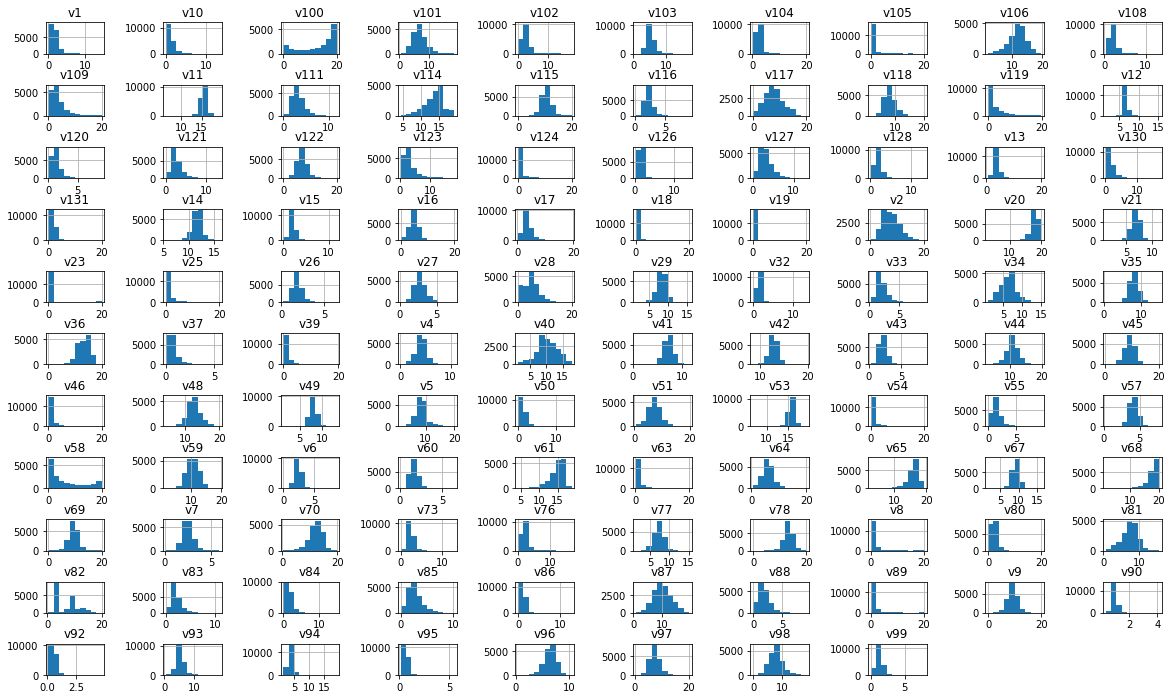

In [20]:
df[float_features].hist(figsize = (20, 12), bins = 10);
plt.subplots_adjust(wspace = 1, hspace = 1);


In [21]:
# У многих признаков график распределения похож на нормальный


## Целевая переменная:

In [22]:
df['target'].value_counts()


1    12403
0     5353
Name: target, dtype: int64

In [23]:
df['target'].value_counts(normalize = True)


1    0.698524
0    0.301476
Name: target, dtype: float64

In [24]:
df['target'].isnull().sum()


0

# Baseline

In [25]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)        
    return X_train_scaled, X_test_scaled


In [26]:
def quality_report(prediction, actual):
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    quality_list = [acc, precision, recall, f1, rocauc]
    
    return quality_list


In [27]:
def fit_prod(data, model):
    X = data.drop('target', axis = 1)
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)    
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)
    
    model.fit(X_train_scaled, y_train)
    pred = model.predict(X_test_scaled)

    quality_list = quality_report(pred, y_test.values)
    
    return quality_list


In [28]:
float_features = [i for i in df if df[i].dtypes == 'float64']
float_features.append('target')
len(float_features)


109

In [29]:
df_list = fit_prod(df[float_features], LogisticRegression(solver = "liblinear"))

df_quality = pd.DataFrame([df_list], 
                          columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
                          index=["baseline LogReg"]
                         )
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614


In [30]:
%%time
df_list = fit_prod(df[float_features], KNeighborsClassifier(n_jobs = - 1))
df_quality.loc['baseline KNN'] = df_list
df_quality.round(3)


CPU times: user 24.6 s, sys: 60.9 ms, total: 24.6 s
Wall time: 3.51 s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531


In [31]:
%%time
df_list = fit_prod(df[float_features], SVC(gamma = 'auto'))
df_quality.loc['baseline SVM'] = df_list
df_quality.round(3);


CPU times: user 27.5 s, sys: 279 ms, total: 27.8 s
Wall time: 27.2 s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558


In [32]:
# Логистическая регрессия показывает на baseline лучший ROC-AUC, но Точность и F1-мера выше у SVM.


## Попробуем улучшить оценки путем преобразования данных

### 2. Удалим коррелирующие переменные

In [33]:
float_without_corr = [i for i in df if df[i].dtypes == 'float64']

print(len(float_without_corr))

for i in CorrDel:
    if i in float_without_corr:
        float_without_corr.remove(i)
print(len(float_without_corr))

float_without_corr.append('target')


108
93


In [34]:
df_1 = df.loc[:, float_without_corr]

for c in float_without_corr:
    if df_1[c].isnull().sum() > 0:
        df_1[c] = df_1[c].fillna(df_1[c].median())
df_1.shape


(17756, 94)

In [35]:
%%time
df_list = fit_prod(df_1[float_without_corr], LogisticRegression(solver = "liblinear"))
df_quality.loc['del_corr LogReg'] = df_list
df_quality.round(3)


CPU times: user 1.93 s, sys: 41.4 ms, total: 1.97 s
Wall time: 1.37 s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607


### Используем категориальные признаки:


In [36]:
df_2 = df.drop(CorrDel, axis = 1)
print(df.shape[1], '->', df_2.shape[1])


132 -> 116


In [37]:
object_features = [i for i in df_2 if df_2[i].dtypes == object]
int_features = [i for i in df_2 if df_2[i].dtypes == 'int64']

objects_features = object_features + int_features
objects_features.remove('target')
len(objects_features)


22

In [38]:
object_features = []
len_columns = df_2.columns
len_columns = len_columns.drop('target')
for i in len_columns:
    if df_2[i].nunique() < 100:
        object_features.append(i)

len(object_features)
        

21

In [39]:
%%time
df_22 = pd.get_dummies(data = df_2, columns = object_features, drop_first = True, dtype = int)
print(df_2.shape, '->', df_22.shape)


(17756, 116) -> (17756, 372)
CPU times: user 84.9 ms, sys: 21.9 ms, total: 107 ms
Wall time: 105 ms


In [40]:
object_for_del = [i for i in df_22 if df_22[i].dtypes == object]
object_for_del


['v22']

In [41]:
df_22.drop(object_for_del, axis = 1, inplace = True)


In [42]:
%%time
df_list = fit_prod(df_22, LogisticRegression(solver = "liblinear"))
df_quality.loc['with_categor LogReg'] = df_list
df_quality.round(3)


CPU times: user 6.7 s, sys: 130 ms, total: 6.83 s
Wall time: 5.7 s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619


### Применим регуляризацию:

In [43]:
X_train = df_22.drop('target', axis = 1)
y_train = df_22['target']
X_test = df_22.drop('target', axis = 1)
y_test = df_22['target']
feature_columns = df_22.columns
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)


In [44]:
%%time
model_LogR = LogisticRegression(solver = "liblinear", penalty = "l1")
model_LogR.fit(X_train_scaled, y_train);


CPU times: user 37.5 s, sys: 231 ms, total: 37.7 s
Wall time: 37.5 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


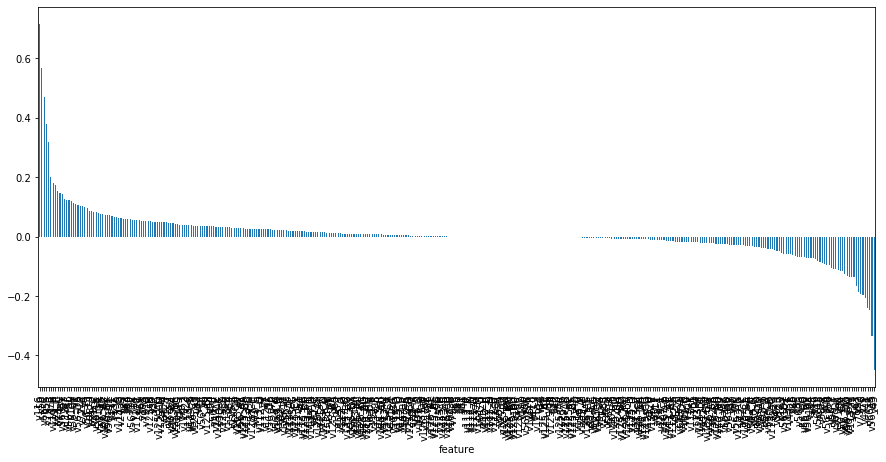

In [45]:
featureImportance = pd.DataFrame({"feature": list(X_train.columns), 
                                  "importance": model_LogR.coef_[0]})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"].plot('bar', figsize=(15, 7));


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


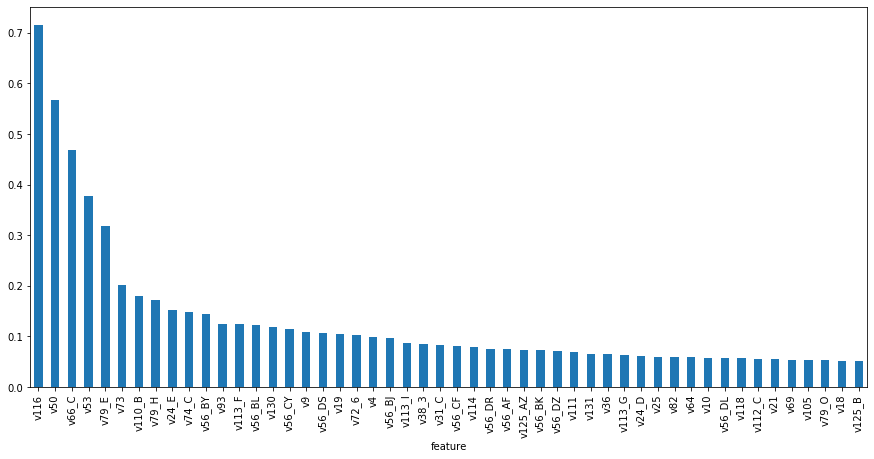

In [46]:
featureImportance = pd.DataFrame({"feature": list(X_train.columns), 
                                  "importance": model_LogR.coef_[0]})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][:50].plot('bar', figsize=(15, 7));


/Users/oleg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


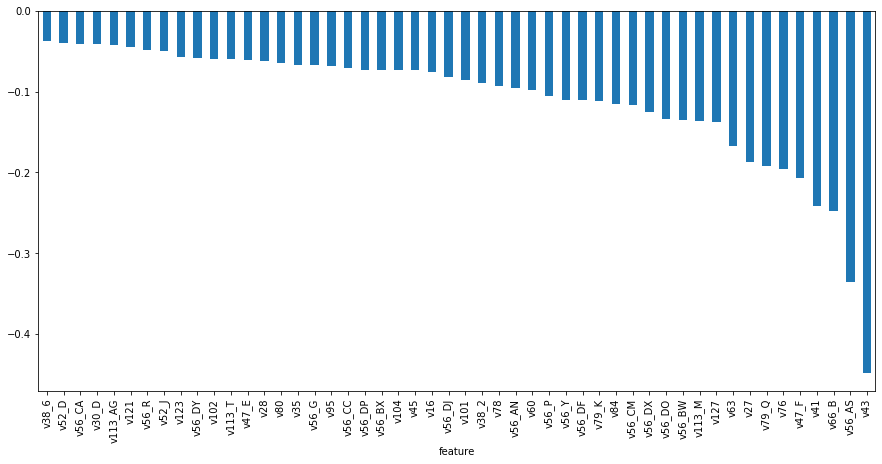

In [47]:
featureImportance = pd.DataFrame({"feature": list(X_train.columns), 
                                  "importance": model_LogR.coef_[0]})

featureImportance.set_index('feature', inplace = True)
featureImportance.sort_values(["importance"], ascending = False, inplace = True)
featureImportance["importance"][-50:].plot('bar', figsize=(15, 7));


In [48]:
top_10 = featureImportance["importance"][:5] + featureImportance["importance"][-5:]
top_10 = list(top_10.index)
top_10.append('target')
len(top_10)


11

In [49]:
top_20 = featureImportance["importance"][:10] + featureImportance["importance"][-10:]
top_20 = list(top_20.index)
top_20.append('target')
len(top_20)


21

In [50]:
top_30 = featureImportance["importance"][:15] + featureImportance["importance"][-15:]
top_30 = list(top_30.index)
top_30.append('target')
len(top_30)


31

In [51]:
df_list = fit_prod(df_22[top_10], LogisticRegression(solver = "liblinear"))
df_quality.loc['top10 LogReg'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636


In [52]:
df_list = fit_prod(df_22[top_20], LogisticRegression(solver = "liblinear"))
df_quality.loc['top20 LogReg'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661


In [53]:
df_list = fit_prod(df_22[top_30], LogisticRegression(solver = "liblinear"))
df_quality.loc['top30 LogReg'] = df_list
df_quality.round(3)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661
top30 LogReg,0.711,0.946,0.723,0.819,0.657


# Выбор модели:

In [54]:
%%time
df_list = fit_prod(df_22[top_20], KNeighborsClassifier(n_jobs = - 1))
df_quality.loc['top20 KNN'] = df_list
df_quality.round(3)


CPU times: user 4.42 s, sys: 16.8 ms, total: 4.43 s
Wall time: 866 ms


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661
top30 LogReg,0.711,0.946,0.723,0.819,0.657
top20 KNN,0.663,0.832,0.724,0.774,0.574


In [55]:
%%time
df_list = fit_prod(df_22[top_20], SVC(gamma = 'auto'))
df_quality.loc['top20 SVM'] = df_list
df_quality.round(3)


CPU times: user 8.63 s, sys: 123 ms, total: 8.75 s
Wall time: 8.75 s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661
top30 LogReg,0.711,0.946,0.723,0.819,0.657
top20 KNN,0.663,0.832,0.724,0.774,0.574
top20 SVM,0.704,0.962,0.712,0.819,0.647


## Поиграем с параметрами SVC

In [58]:
df_4 = df_22[top_20].copy()


In [59]:
svc = SVC()

parameters_kernel = {'kernel': ('sigmoid', 'linear', 'poly', 'rbf')}
parameters_C = {'C': [0.1, 1, 10, 100]}
parameters_gamma = {'gamma': [0.001, 0.01, 0.1, 1., 10, 100]}


In [60]:
%%time

clf = GridSearchCV(svc, parameters_kernel, cv = 3, n_jobs = -1)

search = clf.fit(df_4.drop('target', axis = 1), df_4.loc[:, 'target'])
search.best_params_
my_kernel = search.best_params_['kernel']
my_kernel


CPU times: user 18 s, sys: 257 ms, total: 18.2 s
Wall time: 39.2 s


'poly'

In [61]:
%%time

clf = GridSearchCV(svc, parameters_C, cv = 3, n_jobs = -1)

search = clf.fit(df_4.drop('target', axis = 1), df_4.loc[:, 'target'])

my_C = search.best_params_['C']
my_C


CPU times: user 44.8 s, sys: 475 ms, total: 45.3 s
Wall time: 1min 39s


100

In [68]:
%%time

parameters_C2 = {'C': [70, 100, 200]}

clf = GridSearchCV(svc, parameters_C2, cv = 3, n_jobs = - 1)

search = clf.fit(df_4.drop('target', axis = 1), df_4.loc[:, 'target'])

print(search.best_params_)

my_C = search.best_params_['C']


CPU times: user 1min 14s, sys: 674 ms, total: 1min 15s
Wall time: 2min 31s


{'C': 200}

In [69]:
%%time

parameters_C3 = {'C': [200, 300, 500]}

clf = GridSearchCV(svc, parameters_C3, cv = 3, n_jobs = - 1)

search = clf.fit(df_4.drop('target', axis = 1), df_4.loc[:, 'target'])

print(search.best_params_)

my_C = search.best_params_['C']


CPU times: user 1min 12s, sys: 701 ms, total: 1min 13s
Wall time: 2min 13s


{'C': 200}

In [65]:
%%time

clf = GridSearchCV(svc, parameters_gamma, cv = 3, n_jobs = -1)

search = clf.fit(df_4.drop('target', axis = 1), df_4.loc[:, 'target'])
my_gamma = search.best_params_['gamma']
my_gamma


CPU times: user 16.4 s, sys: 308 ms, total: 16.7 s
Wall time: 2min 13s


0.1

In [72]:
%%time
df_list = fit_prod(df_4, SVC(gamma = my_gamma, C = my_C, kernel = my_kernel))
df_quality.loc['top20 SVM_opt'] = df_list
df_quality.round(3)


CPU times: user 1h 27s, sys: 16 s, total: 1h 43s
Wall time: 1h 59s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline LogReg,0.696,0.957,0.708,0.814,0.614
baseline KNN,0.640,0.827,0.705,0.761,0.531
baseline SVM,0.693,0.994,0.695,0.818,0.558
del_corr LogReg,0.695,0.958,0.707,0.813,0.607
with_categor LogReg,0.697,0.902,0.727,0.805,0.619
top10 LogReg,0.703,0.949,0.716,0.816,0.636
top20 LogReg,0.711,0.951,0.721,0.820,0.661
top30 LogReg,0.711,0.946,0.723,0.819,0.657
top20 KNN,0.663,0.832,0.724,0.774,0.574
top20 SVM,0.704,0.962,0.712,0.819,0.647
